# Preparing libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import string 
import warnings 
import seaborn as sns 
import matplotlib.pyplot as plt  

# For auto-reload
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
PATH = "../data"

In [2]:
#Load spacy models
!python -m spacy download en_core_web_md

     |████████████████████████████████| 50.8 MB 6.2 MB/s eta 0:00:01
  Created wheel for en-core-web-md: filename=en_core_web_md-2.3.1-py3-none-any.whl size=50916640 sha256=fd48e11df3f7ca6f9b58ce0625fd7ccbe90b17f6b780fe04f8fc3d2809134fee
  Stored in directory: /tmp/pip-ephem-wheel-cache-n5smohzr/wheels/b8/ae/ae/c63bae74a3b3e18b2fa35e179387e6cdeb03a1c479ed45c351
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


# Loading raw data - Exploration

In [3]:
import pandas as pd

# load data
df = pd.read_json(f'{PATH}/raw/News_Category_Dataset_v2.json', lines=True)


In [4]:
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [5]:
df.dtypes

category                     object
headline                     object
authors                      object
link                         object
short_description            object
date                 datetime64[ns]
dtype: object

In [6]:
df.describe()

<ipython-input-6-ea8415b8a3ee>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,category,headline,authors,link,short_description,date
count,200853,200853,200853,200853,200853,200853
unique,41,199344,27993,200812,178353,2309
top,POLITICS,Sunday Roundup,,https://www.huffingtonpost.comhttps://www.publ...,,2013-01-17 00:00:00
freq,32739,90,36620,2,19712,100
first,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2018-05-26 00:00:00


## Categories sizes

In [7]:
categories = df.groupby('category')
print("total categories:", categories.ngroups)
print(categories.size())

total categories: 41
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST 

<AxesSubplot:ylabel='category'>

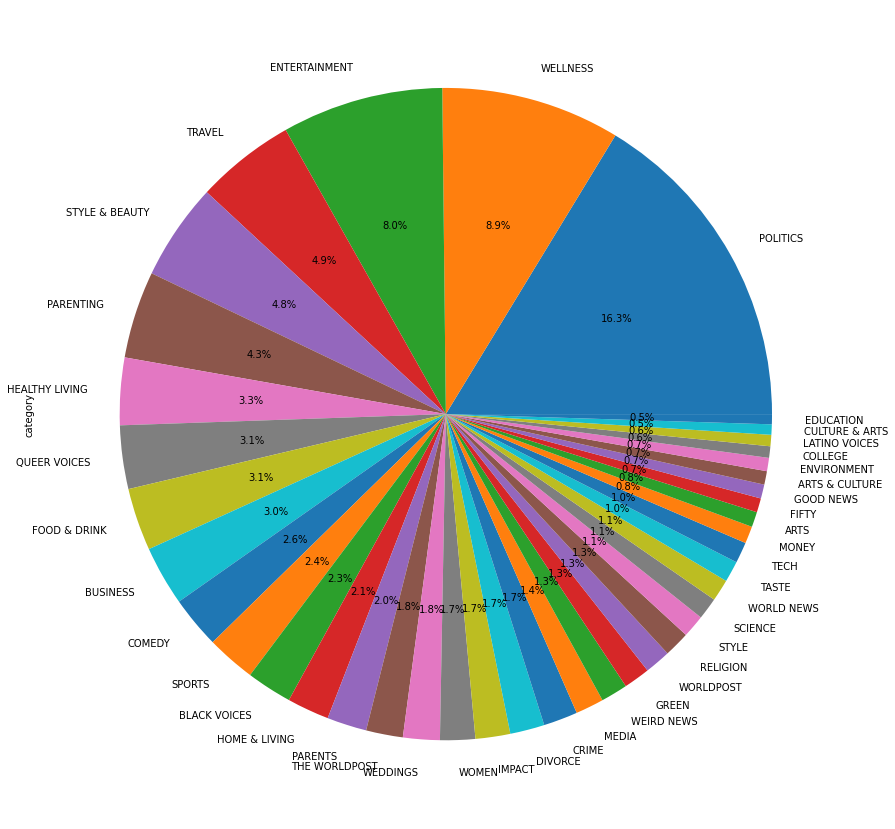

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
df['category'].value_counts().plot.pie( autopct = '%1.1f%%')

## Merging categories
Many categories represent the same underlying category. Let us merge them together. 

In [9]:
def category_cleaner(x):
    
    if x == 'THE WORLDPOST':
        return 'WORLDPOST'
    elif x == 'PARENTING':
        return 'PARENTS'
    elif x == 'ARTS' or x == 'CULTURE & ARTS':
        return 'ARTS & CULTURE'
    elif x == 'STYLE':
        return 'STYLE & BEAUTY'
    elif x == 'COLLEGE':
        return 'EDUCATION'
    elif x == 'TASTE':
        return 'FOOD & DRINK'
    else:
        return x
    
df['category'] = df.category.apply(category_cleaner)

<AxesSubplot:ylabel='category'>

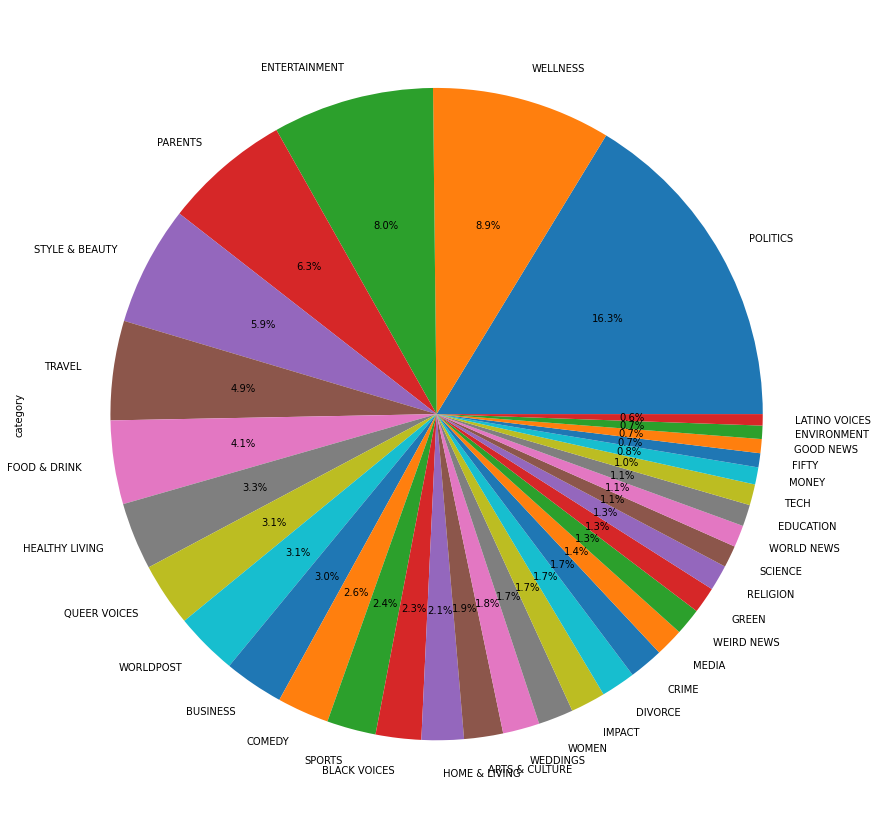

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
df['category'].value_counts().plot.pie( autopct = '%1.1f%%')

## Text field

For our text classifier, we will use data from the headline and the description as input. Since we want to build a text classifier that can be used for any text given by the user, we will ommit the writer name and other info. One should note that adding the writer name can bring a lot of information to the classifier.

In [11]:
df['text'] = df.headline + " " + df.short_description

## Text Preprocessing

In [12]:
# function to remove non-ASCII chars from data
def clean_ascii(text):
    return ''.join(i for i in text if ord(i) < 128)

df['text'] = df['text'].apply(clean_ascii)

In [13]:
# Number of caracters in the text
df['len_text'] = df.text.apply(lambda i: len(i))

In [14]:
df['len_text'].describe()

count    200853.000000
mean        173.048787
std          79.890130
min           1.000000
25%         120.000000
50%         170.000000
75%         208.000000
max        1487.000000
Name: len_text, dtype: float64

<AxesSubplot:>

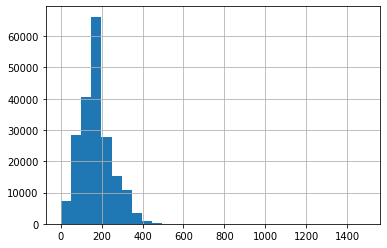

In [15]:
df.len_text.hist(bins=30)

# Spacy preprocessing

when you call spaCy's nlp(), it runs everything in its pipeline by default, including part-of-speech tagging, dependency parsing, and NER. If you just need lemmazing, you can turn some of those off: https://spacy.io/usage/processing-pipelines#disabling


In [16]:
import en_core_web_md
import spacy

# Load spacy nlp model
nlp = en_core_web_md.load(disable=["tagger", "parser", "ner"])
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [17]:
# Tokenize and lemmatize

def keep_token(t):
    return (t.is_alpha and 
            not (t.is_space or t.is_punct or 
                 t.is_stop or t.like_num))

def lemmatize_doc(doc):
    return [ t.lemma_ for t in doc if keep_token(t)]

In [ ]:
%%time
df['clean_text'] = df.text.apply(lambda x: ' '.join(lemmatize_doc(nlp(x.lower()))))

Discover vocabulary size

In [19]:
len_seq = []
vocabulary = []

for i in df.index:
    tokens = df["clean_text"][i].split(" ")
    len_seq.append(len(tokens))
    vocabulary.append(tokens)

assert len(len_seq) == df.shape[0]

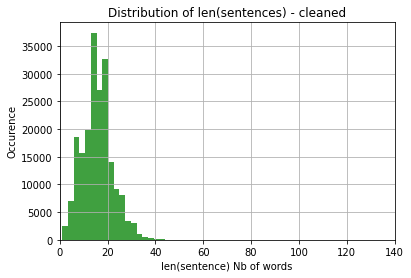

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(len_seq, 50, density=False, facecolor="g", alpha=0.75)

plt.xlabel("len(sentence) Nb of words")
plt.ylabel("Occurence")
plt.title("Distribution of len(sentences) - cleaned")
plt.xlim(0, 140)
plt.grid(True)
plt.show()

In [ ]:
all_tokens = np.hstack(vocabulary)

print('total number of tokens in training:', len(all_tokens))
print('unique tokens:', len(np.unique(all_tokens)))

In [0]:
data_to_save = df[['text', 'clean_text', 'category']]

In [0]:
data_to_save.head()

,text,clean_text,category
0,There Were 2 Mass Shootings In Texas Last Week...,mass shooting texas week tv leave husband kill...,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2...,smith join diplo nicky jam world cup official ...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 5...,hugh grant marry time age actor longtime girlf...,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,jim carrey blast castrato adam schiff democrat...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,julianna margulies use donald trump poop bag p...,ENTERTAINMENT


# Save to feather

Save results of preprocessing for faster iteration later.

In [0]:
# Save to feather
data_to_save.to_feather(f'{PATH}/dataset_processed')

## Balanced dataset

In [0]:
# Balance classes:
import random
random.seed(42)

cat = data_to_save.category.unique()
d = []
nb_obs = 1004

for c in cat:
    df_class_c = data_to_save[data_to_save['category'] == c]
    d.append(df_class_c.loc[random.sample(list(df_class_c.index),nb_obs)])

In [0]:
df_balance = pd.concat(d, axis=0)

In [0]:
df_balance = df_balance.reset_index()

In [0]:
df_balance.to_feather(f'{PATH}/dataset_processed_balanced')